**Membuat Sistem Rekomendasi Film Menggunakan Machine Learning**

---
Sistem ini dibuat untuk memenuhi tugas Submission Kelas Machine Learning Terapan yang difasilitasi oleh Kementerian Pariwisata dan Ekonomi Kreatif (Kemenparekraf) bekerjasama dengan Dicoding.

---
Untuk membuat sistem rekomendasi film menggunakan machine learning, pertama import library dan module yang dibutuhkan.

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from tensorflow.keras import layers
from numpy import sqrt
from sklearn.metrics import mean_squared_error

**Install library Kaggle**

---

Menginstal library tambahan yang dibutuhkan. Dalam hal ini, library Kaggle yang nantinya akan digunakann untuk load dataset dari situs Kaggle

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Mount Google Drive Ke Dalam Google Colab**

---
Memberikan izin akses Google Colab untuk menggunakan Google Drive. Tujuannya, Agar dataset yang telah di download dari situs Kaggle tidak hilang saat session timeout, karena dataset tersebut telah disimpan pada Google Drive.

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Pengatur Path Penyimpanan Dataset**

---
Mengatur path (direktori/folder) yang akan digunakan dalam penyimpanan dataset.

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/recommendation'
%cd /content/gdrive/MyDrive/recommendation

/content/gdrive/MyDrive/recommendation


**Download Dataset**

---
Download dataset dari situs Kaggle untuk digunakan dalam pembuatan Recommendation System

In [ ]:
!kaggle datasets download -d hariprabu/imdb-1000

imdb-1000.zip: Skipping, found more recently modified local copy (use --force to force download)


**Ekstrak Dataset**

---
Ekstrak dataset yang masih dalam file .zip

In [ ]:
!unzip /content/gdrive/MyDrive/recommendation/imdb-1000.zip

unzip:  cannot find or open /content/gdrive/MyDrive/recommendation/imdb-1000.zip, /content/gdrive/MyDrive/recommendation/imdb-1000.zip.zip or /content/gdrive/MyDrive/recommendation/imdb-1000.zip.ZIP.


**Load Dataset**

---
Dataset yang telah tersedia di Google Drive, kemudian di load untuk dianalisis lebih lanjut.

In [ ]:
movies = pd.read_csv('/content/gdrive/MyDrive/recommendation/movies.csv')
ratings = pd.read_csv('/content/gdrive/MyDrive/recommendation/ratings.csv')

print('Jumlah film dalam dataset movies: ', len(movies.movieId.unique()))
print('Jumlah user yang memberikan rating: ', len(ratings.userId.unique()))

Jumlah film dalam dataset movies:  9125
Jumlah user yang memberikan rating:  610


**Memeriksa Nama Variabel dan Missing Value Dataset movies**

---
Memeriksa nama variabel yang digunakan pada dataset movies serta missing valuenya.

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9125 non-null   int64 
 1   title    9125 non-null   object
 2   genres   9125 non-null   object
dtypes: int64(1), object(2)
memory usage: 214.0+ KB


**Memeriksa Nama Variabel dan Missing Value Dataset ratings**

---
Memeriksa nama variabel yang digunakan pada dataset ratings dan missing valuenya.

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


**Menggabungkan Dataset movies dan ratings**

---
Agar dataset dapat dianalisis dengan menggunakan pendekatan Content Based Filtering dan Collaborative Filtering, maka dataset Movies dan Ratings harus digabungkan.

In [ ]:
movies_with_ratings = pd.concat([movies, ratings])
movies_with_ratings = pd.merge(movies, ratings, on='movieId', how='left')
movies_with_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
...,...,...,...,...,...,...
98859,162672,Mohenjo Daro (2016),Adventure|Drama|Romance,NaN,NaN,NaN
98860,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi,380.0,4.0,1.501787e+09
98861,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary,NaN,NaN,NaN
98862,164977,The Gay Desperado (1936),Comedy,NaN,NaN,NaN


**Memeriksa Kembali Missing Value Dataset Gabungan**

---
Memeriksa kembali missing value dataset gabungan antara movies dan ratings.


In [ ]:
movies_with_ratings.isnull().sum()

movieId         0
title           0
genres          0
userId       2053
rating       2053
timestamp    2053
dtype: int64

**Membuang Missing Value**

---
Membuang missing value yang muncul setelah penggabungan dataset movies dan ratings


In [ ]:
movies_with_ratings = movies_with_ratings.dropna()
movies_with_ratings.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

**Membuang Data Duplikat**

---
Membuang data duplikat yang terdapat pada dataframe movies_with_ratings.

In [ ]:
movies_with_ratings = movies_with_ratings.drop_duplicates('movieId')
movies_with_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
215,2,Jumanji (1995),Adventure|Children|Fantasy,6.0,4.0,8.455535e+08
325,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,9.649812e+08
377,4,Waiting to Exhale (1995),Comedy|Drama|Romance,6.0,3.0,8.455543e+08
384,5,Father of the Bride Part II (1995),Comedy,6.0,5.0,8.455539e+08
...,...,...,...,...,...,...
98845,161582,Hell or High Water (2016),Crime|Drama,18.0,4.0,1.499632e+09
98853,161594,Kingsglaive: Final Fantasy XV (2016),Action|Adventure|Animation|Drama|Fantasy|Sci-Fi,184.0,3.5,1.537108e+09
98854,161830,Body (2015),Drama|Horror|Thriller,448.0,1.0,1.472493e+09
98855,161918,Sharknado 4: The 4th Awakens (2016),Action|Adventure|Horror|Sci-Fi,448.0,1.5,1.472930e+09


**Melihat Detail Dataset**

---
Melihat detail dataset yang digunakan dengan menggunakan describe()

In [ ]:
movies_with_ratings.describe()

,movieId,userId,rating,timestamp
count,7072.000000,7072.000000,7072.000000,7.072000e+03
mean,27773.466770,173.835831,3.308046,1.190420e+09
std,39119.853334,181.459312,1.095217,2.106644e+08
min,1.000000,1.000000,0.500000,8.297598e+08
25%,2464.500000,20.000000,2.500000,9.878957e+08
50%,5387.500000,91.000000,3.500000,1.161850e+09
75%,49278.500000,298.000000,4.000000,1.422225e+09
max,163056.000000,610.000000,5.000000,1.537108e+09


**Mencari Outliers**

---
Untuk mencari data yang bias pada set, kita akan mencari outliers pada variabel rating. Alasannya, karena variable rating memungkinkan adanya penilaian yang bias terhadap kualitas suatu film.

<Axes: xlabel='rating'>

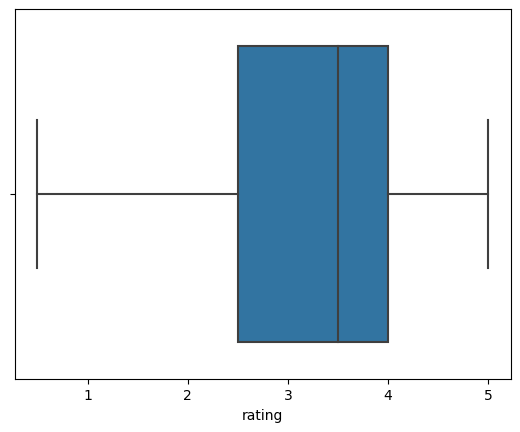

In [ ]:
sns.boxplot(x=movies_with_ratings['rating'])

**Visualisasi Data**

---
Melakukan visualisasi data untuk melihat komposisi data pada variabel rating.

     jumlah sampel  persentase
4.0           1661        23.5
3.0           1445        20.4
3.5            955        13.5
2.0            768        10.9
5.0            730        10.3
4.5            486         6.9
2.5            435         6.2
1.0            285         4.0
1.5            174         2.5
0.5            133         1.9


<Axes: >

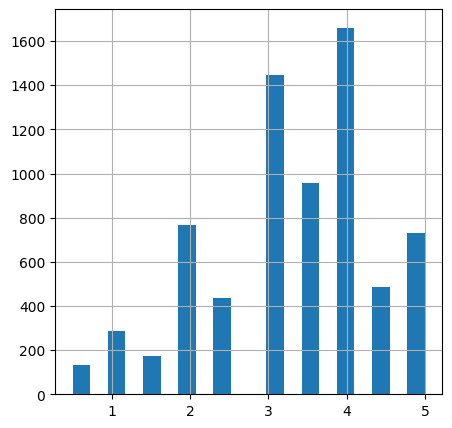

In [ ]:
count = movies_with_ratings['rating'].value_counts()
percent = 100*movies_with_ratings['rating'].value_counts(normalize=True)
df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df)
movies_with_ratings['rating'].hist(bins=20, figsize=(5,5))

**Membuat Data List Untuk Input Sistem Rekomendasi Content Based Filtering**

---
Untuk membuat sistem rekomendasi content based filtering, maka dibuat list yang berasal dari variabel movieId, title, genres.


In [ ]:
movieId = movies_with_ratings['movieId'].tolist()
title = movies_with_ratings['title'].tolist()
genres = movies_with_ratings['genres'].tolist()

print(len(movieId))
print(len(title))
print(len(genres))

7072
7072
7072


**Membuat Dataframe dari List**

---
Membuat dataframe untuk sistem rekomendasi content based filtering dari list movieId, title dan genres.


In [ ]:
movie_content = pd.DataFrame({
    'id': movieId,
    'title': title,
    'genres': genres
})
movie_content

,id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
7067,161582,Hell or High Water (2016),Crime|Drama
7068,161594,Kingsglaive: Final Fantasy XV (2016),Action|Adventure|Animation|Drama|Fantasy|Sci-Fi
7069,161830,Body (2015),Drama|Horror|Thriller
7070,161918,Sharknado 4: The 4th Awakens (2016),Action|Adventure|Horror|Sci-Fi


**Menggunakan TF-IDF Vectorizer**

---
Menggunakan TF-IDF Vectorizer untuk proses pembobotan nilai.


In [ ]:
# Inisialisasi penggunaan TF-IDF Vectorizer
tf = TfidfVectorizer()

# Mempelajari kata yang terdapat pada movie_content['Genres']
tf.fit(movie_content['genres'])

# Tampilkan kata-kata yang telah dipelajari
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

**Melakukan Data Fit dan Mengubah kedalam Bentuk Matrix**

---
Melakukan Data Fit hasil TF-IDF dan Mengubah kedalam Bentuk Matrix.


In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(movie_content['genres']) 

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(7072, 24)

**Mengubah Sparse Matrix Menjadi Dense Matrix**

---
Mengubah sparse Matrix ke dalam bentuk dense matrix.


In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.40574538, 0.53561548, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.5065915 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.56077836, 0.        ,
         0.        ],
        [0.37625256, 0.42520187, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.37194914, 0.42033859, 0.        , ..., 0.        , 0.        ,
         0.        ]])

**Menampilkan Dataframe yang telah diolah**
---
Menampilkan dataframe yang telah dilakukan pengolahan data.


In [ ]:
# Menampilkan Dataframe
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=movie_content.title
).sample(15, axis=1).sample(10, axis=0)

,western,fi,no,listed,adventure,thriller,comedy,imax,animation,children,sci,romance,noir,action,film
title,,,,,,,,,,,,,,,
Foxfire (1996),0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
Howard the Duck (1986),0.0,0.562742,0.0,0.0,0.50546,0.000000,0.333397,0.0,0.0,0.0,0.562742,0.000000,0.0,0.000000,0.0
Belle époque (1992),0.0,0.000000,0.0,0.0,0.00000,0.000000,0.582803,0.0,0.0,0.0,0.000000,0.812613,0.0,0.000000,0.0
Rush Hour 3 (2007),0.0,0.000000,0.0,0.0,0.00000,0.497300,0.380388,0.0,0.0,0.0,0.000000,0.000000,0.0,0.510312,0.0
Funny Games U.S. (2007),0.0,0.000000,0.0,0.0,0.00000,0.823876,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
Georgia (1995),0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
"Invisible Man, The (1933)",0.0,0.575068,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.575068,0.000000,0.0,0.000000,0.0
Boyz N the Hood (1991),0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
"Final Conflict, The (a.k.a. Omen III: The Final Conflict) (1981)",0.0,0.000000,0.0,0.0,0.00000,0.607829,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


**Menghitung Cosine Similarity**

---
Menghitung derajat kesamaan dengan menggunakan cosine similarity.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
 
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.80093207, 0.15597355, ..., 0.        , 0.17252369,
        0.40894611],
       [0.80093207, 1.        , 0.        , ..., 0.        , 0.21540365,
        0.51058776],
       [0.15597355, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.35091823,
        0.        ],
       [0.17252369, 0.21540365, 0.        , ..., 0.35091823, 1.        ,
        0.76174258],
       [0.40894611, 0.51058776, 0.        , ..., 0.        , 0.76174258,
        1.        ]])

**Membuat Dataframe dari Hasil Cosine Similarity**

---
Membuat Dataframe dari Hasil Cosine Similarity untuk mengetahui perbandingan derajat kesamaan,


In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_content['title'], columns=movie_content['title'])
print('Shape:', cosine_sim_df.shape)
 
cosine_sim_df.sample(5, axis=1).sample(5, axis=0)

Shape: (7072, 7072)


title,"Believers, The (1987)","Mechanic, The (2011)",You Will Meet a Tall Dark Stranger (2010),Marty (1955),Any Which Way You Can (1980)
title,,,,,
Onibaba (1964),0.472755,0.135691,0.000000,0.169935,0.000000
American Heist (2015),0.000000,0.645621,0.000000,0.000000,0.000000
Sex and Lucia (Lucía y el sexo) (2001),0.000000,0.234606,0.682880,1.000000,0.000000
"Faculty, The (1998)",0.462059,0.000000,0.000000,0.000000,0.000000
Together (Tillsammans) (2000),0.000000,0.200934,0.885706,0.856473,0.516193


**Membuat Function Untuk Content Based Filtering**

---
Membuat function dengan menggunakan bahasa python untuk membuat sistem rekomendasi Content Based Filtering.

In [ ]:
def movie_recommendation_CBF(title, similarity_data=cosine_sim_df, items=movie_content[['title', 'genres']], k=5):
   
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))
    
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(title, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

**Mencoba Hasil Sistem Rekomendasi Content Based Filtering**

---
Mencoba Hasil Sistem Rekomendasi Content Based Filtering dengan menginput judul film Ace Ventura: When Nature Calls (1995).


In [ ]:
movie_recommendation_CBF('Ace Ventura: When Nature Calls (1995)')

,title,genres
0,Shower (Xizao) (1999),Comedy
1,Children of the Revolution (1996),Comedy
2,Borat: Cultural Learnings of America for Make ...,Comedy
3,Romy and Michele's High School Reunion (1997),Comedy
4,8 Heads in a Duffel Bag (1997),Comedy


**Memeriksa keakuratan Hasil Sistem Rekomendasi**

---
Untuk memeriksa, keakuratan hasil sistem rekomendasi Content Based Learning, kita memeriksa genre dari judul film yang diinput.

In [ ]:
movie_content[movie_content.title.eq('Ace Ventura: When Nature Calls (1995)')]

,id,title,genres
18,19,Ace Ventura: When Nature Calls (1995),Comedy


**Data Preparation Untuk Sistem Rekomendasi Collaborative Filtering**

---
Melakukan proses Data Preparation Untuk Sistem Rekomendasi Collaborative Filtering dengan cara menyiapkan data Id Pengguna

In [ ]:
# Mengubah data id_pengguna menjadi list tanpa nilai duplikat
id_pengguna = ratings['userId'].unique().tolist()
print('Daftar id_pengguna: ', id_pengguna)
 
# Melakukan proses encoding id_pengguna
encoding_id_pengguna = {x: i for i, x in enumerate(id_pengguna)}
print('id_pengguna diencoding : ', encoding_id_pengguna)
 
# Melakukan proses encoding angka ke ke id_pengguna
user_encoding_to_user = {i: x for i, x in enumerate(id_pengguna)}
print('encoding angka ke id_pengguna: ', encoding_id_pengguna)

Daftar id_pengguna:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 2

**Data Preparation Untuk Variabel movieId**

---
Melakukan proses data preparation pada variabel movieId, agar data dapat digunakan pada sistem rekomendasi Collaborative Filtering.

In [ ]:
# Mengubah id_film menjadi list tanpa duplikat
id_film = ratings['movieId'].unique().tolist()
 
# Melakukan proses encoding id_film
encoding_id_film = {x: i for i, x in enumerate(id_film)}
 
# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(id_film)}
 
# Selanjutnya, petakan userId dan movieId ke dataframe yang berkaitan.
 
# Mapping userId ke dataframe genres
ratings['genres'] = ratings['userId'].map(encoding_id_pengguna)
 
# Mapping movieId ke dataframe movies
ratings['movies'] = ratings['movieId'].map(encoding_id_film)

**Menganalisis Data Untuk Collaborative Filtering**

---
Melakukan analisis data untuk Collaborative Filtering.

In [ ]:
total_users = len(encoding_id_pengguna)
print(total_users)
 
total_movies = len(movie_encoded_to_movie)
print(total_movies)
 
ratings['ratings'] = ratings['rating'].values.astype(np.float32)
 
min_rating = min(ratings['rating'])
 
max_rating = max(ratings['rating'])
 
print('Jumlah pengguna: {}, Jumlah Film: {}, Rating Minimal: {}, Rating Maksimal: {}'.format(
    total_users, total_movies, min_rating, max_rating
))

610
9724
Jumlah pengguna: 610, Jumlah Film: 9724, Rating Minimal: 0.5, Rating Maksimal: 5.0


**Menetapkan Random State Untuk Dataframe**

---
Menetapkan Random State Pada Dataframe yang akan digunakan pada sistem rekomendasi Collaborative Filtering.

In [ ]:
df = ratings.sample(frac=1, random_state=40)
df

,userId,movieId,rating,timestamp,genres,movies,ratings
20567,135,3360,3.0,1009693935,134,2204,3.0
70093,448,98296,1.5,1367270204,447,7869,1.5
74428,474,5349,4.5,1100291637,473,756,4.5
3469,21,63082,3.5,1468113389,20,1915,3.5
4439,28,4027,3.5,1242031777,27,436,3.5
...,...,...,...,...,...,...,...
56760,377,6899,3.5,1340343436,376,7106,3.5
93176,599,1623,2.5,1498516912,598,8881,2.5
80037,501,849,3.0,844974390,500,263,3.0
30727,216,125,5.0,975212597,215,297,5.0


**Membagi Data Train dan Data Validasi**

---
Membuat variabel x dan y untuk membagi data train dan data validasi pada dataset yang digunakan.

In [ ]:
x = df[['genres', 'movies']].values
 
y = df['ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi dataset menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[ 134 2204]
 [ 447 7869]
 [ 473  756]
 ...
 [ 500  263]
 [ 215  297]
 [  67  958]] [0.55555556 0.22222222 0.88888889 ... 0.55555556 1.         0.55555556]


**Membuat Fungsi Untuk Collaborative Filtering**

---
Membuat fungsi dengan menggunakan bahasa python untuk sistem rekomendasi Collaborative Filtering.

In [ ]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movies
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movies bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

**Melakukan Compile data**

---
Melakukan compile data untuk persiapan proses pelatihan data.

In [ ]:
model = RecommenderNet(total_users, total_movies, 50)
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

**Proses Pelatihan Data**

---
Proses Pelatihan data sebanyak 100 epoch.

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1261/1261 [==============================] - 15s 11ms/step - loss: 0.6392 - root_mean_squared_error: 0.2352 - val_loss: 0.6192 - val_root_mean_squared_error: 0.2137
Epoch 2/100
1261/1261 [==============================] - 12s 9ms/step - loss: 0.6148 - root_mean_squared_error: 0.2097 - val_loss: 0.6204 - val_root_mean_squared_error: 0.2145
Epoch 3/100
1261/1261 [==============================] - 11s 9ms/step - loss: 0.6095 - root_mean_squared_error: 0.2040 - val_loss: 0.6133 - val_root_mean_squared_error: 0.2071
Epoch 4/100
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6073 - root_mean_squared_error: 0.2014 - val_loss: 0.6112 - val_root_mean_squared_error: 0.2049
Epoch 5/100
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6075 - root_mean_squared_error: 0.2015 - val_loss: 0.6108 - val_root_mean_squared_error: 0.2045
Epoch 6/100
1261/1261 [==============================] - 11s 9ms/step - loss: 0.6069 - root_mean_squared_error: 0.2006 

**Visualisasi Hasil Pelatihan Data**

---
Visualisasi metriks hasil pelatihan data dengan melihat metrik root_mean_squared_error dan metrik val_root_mean_squared_error.


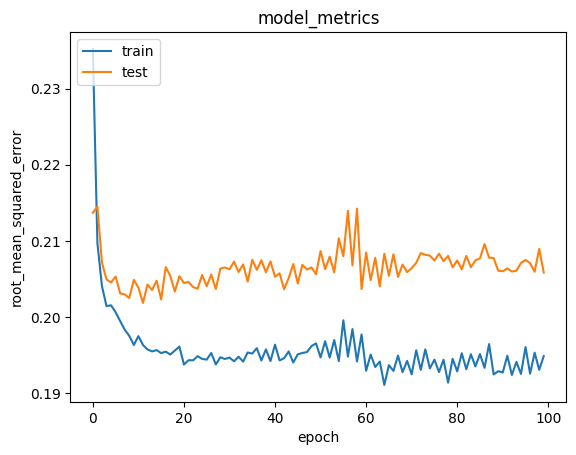

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Persiapan Proses Penggunakan Sistem Collaborative Filtering**

---
Melakukan Persiapan Proses Penggunakan Sistem Collaborative Filtering.

In [ ]:
movie_df = movie_content
df = pd.read_csv('/content/gdrive/MyDrive/recommendation/ratings.csv')
 

user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]
 

movie_not_watched = movie_df[~movie_df['id'].isin(movie_watched_by_user.movieId.values)]['id'] 
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(encoding_id_film.keys()))
)
 
movie_not_watched = [[encoding_id_film.get(x)] for x in movie_not_watched]
user_encoder = encoding_id_pengguna.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

**Mencoba Hasil Sistem Rekomendasi Collaborative Filtering**

---
Mencoba Hasil Sistem Rekomendasi Collaborative Filtering.

In [ ]:
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Menampilkan Rekomendasi Untuk User: {}'.format(user_id))
print('===' * 9)
print('Judul Film yang Memiliki Rating Tinggi dari User')
print('----' * 8)
 
top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)
 
print('----' * 8)
print('Top 10 Rekomendasi Film')
print('----' * 8)
 
recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

215/215 [==============================] - 0s 1ms/step
Menampilkan Rekomendasi Untuk User: 594
Judul Film yang Memiliki Rating Tinggi dari User
--------------------------------
Three Musketeers, The (1993) : Action|Adventure|Comedy|Romance
Terminator 2: Judgment Day (1991) : Action|Sci-Fi
Terminator, The (1984) : Action|Sci-Fi|Thriller
Serendipity (2001) : Comedy|Romance
--------------------------------
Top 10 Rekomendasi Film
--------------------------------
Lamerica (1994) : Adventure|Drama
Heidi Fleiss: Hollywood Madam (1995) : Documentary
Lesson Faust (1994) : Animation|Comedy|Drama|Fantasy
Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975) : Comedy|Drama
Phantom of the Paradise (1974) : Comedy|Fantasy|Horror|Musical|Thriller
Belle époque (1992) : Comedy|Romance
Trial, The (Procès, Le) (1962) : Drama
Troll 2 (1990) : Fantasy|Horror
Enter the Void (2009) : Drama
What We Do in the Shadows (2014) : Comedy|Horror


**Nilai 10% RMSE Untuk Evaluasi Metrik**

---
- Untuk mengukur ketepatan sistem dalam memberikan rekomendasi film sesuai dengan perilaku user, didapatkan bahwa nilai 10% RMSE, yaitu 0.3029659363385887 
- Nilai RMSE error yang didapat pada hasil pelatihan model, yaitu 0.1948 (pada saat training) dan 0.2058 (pada saat validasi).
- Berdasarkan metrik tersebut, maka model sudah dapat dikatakan Good Fit.

In [ ]:
rmse_target = sqrt(mean_squared_error(y, ratings['rating']))
rmse_target = 0.1 * rmse_target
rmse_target

0.3029659363385887